## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [ ]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random

import sinogap_module as sg




### <font style="color:lightblue">Redefine</font>

In [ ]:
sg.plt.rcParams['figure.dpi']=223





### <font style="color:lightblue">Configs</font>

In [ ]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 1
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**10
    ,batchSplit = 16
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 0.00005
    ,learningRateG = 0.00005
)

sg.DCfg = sg.DCfgClass(16)


### <font style="color:lightblue">Raw Read</font>

In [4]:
trainSet = sg.createTrainSet()
testSet = sg.createTestSet()

Done
Loading train set 4 of 9: 18692b.MinceO ... Done
Loading train set 5 of 9: 19022g.11-EggLard ... Done
Loading train set 6 of 9: 19736b.09_Feb.4176862R_Eig_Threshold-4keV ... Done
Loading train set 7 of 9: 19736c.8733147R_Eig_Threshold-8keV.SAMPLE_Y1 ... Done
Loading train set 8 of 9: 20982b.04_774784R ... Done
Loading train set 9 of 9: 23574.8965435L.Eiger.32kev_org ... Done
Loading test set ... Done


### <font style="color:lightblue">Show</font>

-4.021e-01, 1.520e-02, -4.438e-01, -3.493e-01


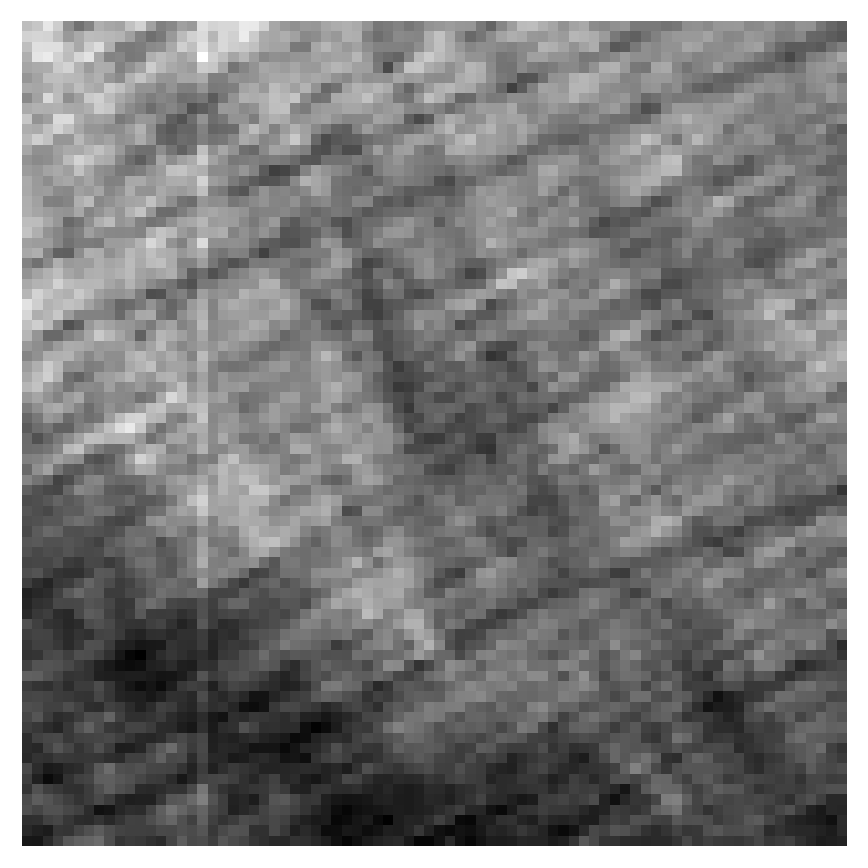

In [ ]:
sg.refImages, sg.refNoises = sg.createReferences(testSet, 1)
sg.showMe(testSet, 0 )

## <font style="color:lightblue">Models</font>

### Generator 2pix

In [6]:


class Generator2(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator2, self).__init__(2)
        self.encoders =  nn.ModuleList([
            self.encblock(  1/self.baseChannels,
                               1, 3, norm=False),
            self.encblock(  1, 1, 3),
            self.encblock(  1, 1, 3),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            self.decblock(2, 1, 3),
            self.decblock(2, 1, 3),
            self.decblock(2, 1, 3, norm=False),
            ])
        self.lastTouch = self.createLastTouch()
        sg.load_model(self, model_path="saves/gap2/noBNreNorm/model_gen.pt" )

generator2 = Generator2()
generator2 = generator2.to(sg.TCfg.device)
generator2 = generator2.requires_grad_(False)
generator2 = generator2.eval()
sg.lowResGenerators[2] = generator2



/home/user/usr/src/sinogap/sinogap_module.py:250: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=TCfg.device))


### Generator 4pix

In [7]:


class Generator4(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator4, self).__init__(4)
        self.encoders =  nn.ModuleList([
            self.encblock( 1/self.baseChannels,
                              1, 3, norm=False),
            self.encblock( 1, 1, 3),
            self.encblock( 1, 2, 3, stride=2),
            self.encblock( 2, 2, 3),
            self.encblock( 2, 4, 3),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            self.decblock(8, 2, 3),
            self.decblock(4, 2, 3),
            self.decblock(4, 1, 4, stride=2),
            self.decblock(2, 1, 3),
            self.decblock(2, 1, 3, norm=False),
            ])
        self.lastTouch = self.createLastTouch()
        sg.load_model(self, model_path="saves/gap4/noBNreNorm/model_gen.pt" )

generator4 = Generator4()
generator4 = generator4.to(sg.TCfg.device)
generator4 = generator4.requires_grad_(False)
generator4 = generator4.eval()
sg.lowResGenerators[4] = generator4





### Generator 8pix

In [8]:


class Generator8(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator8, self).__init__(8)

        self.encoders =  nn.ModuleList([
            self.encblock( 1/self.baseChannels,
                              1, 3, norm=False),
            self.encblock( 1, 1, 3, dopadding=True),
            self.encblock( 1, 2, 3, stride=2),
            self.encblock( 2, 2, 3, dopadding=True),
            self.encblock( 2, 4, 3, stride=2),
            self.encblock( 4, 4, 3, dopadding=True),
            self.encblock( 4, 8, 3, stride=2),
            self.encblock( 8, 8, 3, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(16, 8, 3, dopadding=True),
            self.decblock(16, 4, 4, stride=2),
            self.decblock( 8, 4, 3, dopadding=True),
            self.decblock( 8, 2, 4, stride=2),
            self.decblock( 4, 2, 3, dopadding=True),
            self.decblock( 4, 1, 4, stride=2),
            self.decblock( 2, 1, 3, dopadding=True),
            self.decblock( 2, 1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()
        sg.load_model(self, model_path="saves/gap8/noBNreNorm_tmp/model_gen.pt" )


generator8 = Generator8()
generator8 = generator8.to(sg.TCfg.device)
generator8 = generator8.requires_grad_(False)
generator8 = generator8.eval()
sg.lowResGenerators[8] = generator8

### Generator 16pix

In [9]:


class Generator16(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator16, self).__init__(16,1)

        self.noise2latent = self.createLatent()

        self.encoders =  nn.ModuleList([
            self.encblock( (1+self.latentChannels) /self.baseChannels,
                               1, 3, norm=False),
            self.encblock( 1,  1, 3, dopadding=True),
            self.encblock( 1,  2, 3, stride=2),
            self.encblock( 2,  2, 3, dopadding=True),
            self.encblock( 2,  4, 3, stride=2),
            self.encblock( 4,  4, 3, dopadding=True),
            self.encblock( 4,  8, 3, stride=2),
            self.encblock( 8,  8, 3, dopadding=True),
            self.encblock( 8, 16, 3, stride=2),
            self.encblock(16, 16, 3, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(32, 16, 3, dopadding=True),
            self.decblock(32,  8, 4, stride=2),
            self.decblock(16,  8, 3, dopadding=True),
            self.decblock(16,  4, 4, stride=2),
            self.decblock( 8,  4, 3, dopadding=True),
            self.decblock( 8,  2, 4, stride=2),
            self.decblock( 4,  2, 3, dopadding=True),
            self.decblock( 4,  1, 4, stride=2),
            self.decblock( 2,  1, 3, dopadding=True),
            self.decblock( 2,  1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()
        #sg.load_model(self, model_path="/data/anton/sinogap/tmp/model_noBN_gap16_starter.pt" )

generator16 = Generator16()
generator16 = generator16.to(sg.TCfg.device)
sg.lowResGenerators[16] = generator16




### <font style="color:lightblue">Generator</font>

In [10]:
sg.generator = sg.lowResGenerators[sg.DCfg.gapW]
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
print(model_summary)


Layer (type:depth-idx)                   Output Shape              Param #
Generator16                              [1, 1, 80, 16]            --
├─Sequential: 1-1                        [1, 1, 80, 80]            --
│    └─Linear: 2-1                       [1, 6400]                 416,000
│    └─ReLU: 2-2                         [1, 6400]                 --
│    └─Unflatten: 2-3                    [1, 1, 80, 80]            --
├─ModuleList: 1-2                        --                        --
│    └─Sequential: 2-4                   [1, 64, 78, 78]           --
│    │    └─Conv2d: 3-1                  [1, 64, 78, 78]           1,216
│    │    └─LeakyReLU: 3-2               [1, 64, 78, 78]           --
│    └─Sequential: 2-5                   [1, 64, 78, 78]           --
│    │    └─Conv2d: 3-3                  [1, 64, 78, 78]           36,928
│    │    └─LeakyReLU: 3-4               [1, 64, 78, 78]           --
│    └─Sequential: 2-6                   [1, 128, 38, 38]          --
│  

### <font style="color:lightblue">Discriminator</font>

In [11]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.param = nn.Parameter(torch.zeros(1))
    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=sg.TCfg.device)


sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
#print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



## <font style="color:lightblue">Restore checkpoint</font>

/home/user/usr/src/sinogap/sinogap_module.py:1234: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkPoint = torch.load(path, map_location=TCfg.device)


Initial LR : 4.992987307082619e-06 0.100
Probabilities of reference images: Ref: 0.000e+00, Gen: 0.000e+00, Pre: 0.000e+00.
Distances of reference images: REC: 9.999e-04, MSE: 7.374e-04, L1L: 1.757e-02.


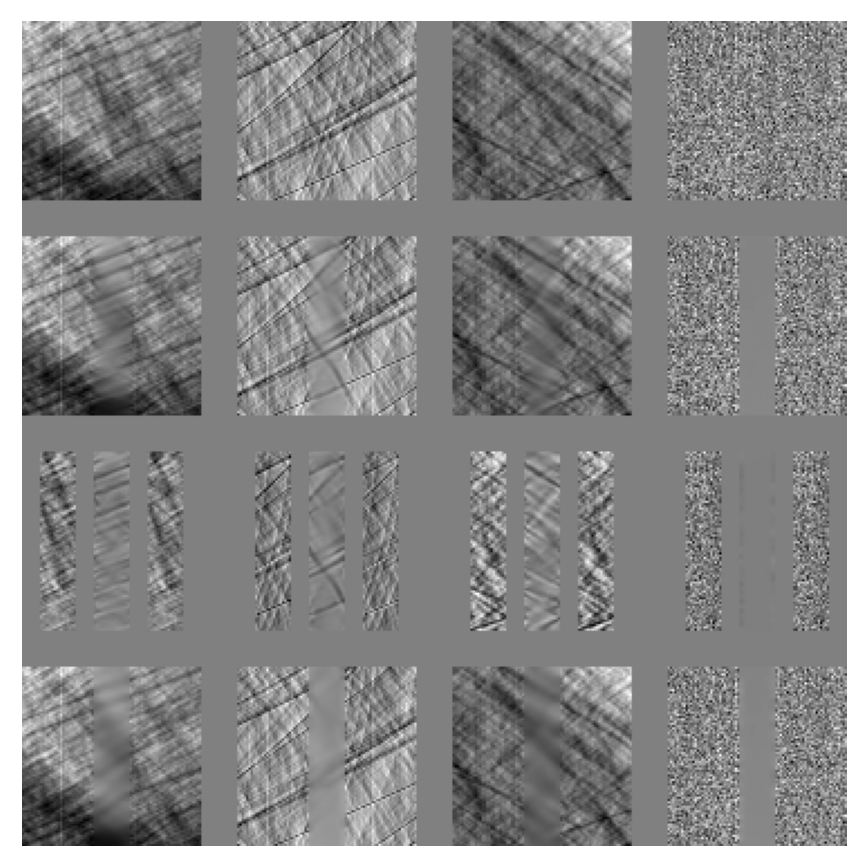

In [20]:
sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=0.999)
sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=0.999)
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint(savedCheckPoint+".pth")
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
#print(sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.scheduler_D.get_last_lr()[0], sg.startFrom)
lastLR = sg.scheduler_D.get_last_lr()[0]
initialLR = sg.TCfg.learningRateD
print(f"Initial LR : {lastLR} {lastLR/initialLR:.3f}")
sg.initialTest()

## <font style="color:lightblue">Execute</font>

LR : 1.6495137047780626e-06 0.033
Epoch: 56 (46).  L1L: 1.001  MSE: 1.682  Rec: 0.942 (Train: 0.921, Test: 0.970 | 0.970).
TT: 0.00,  FT: 0.00,  HD: 2.062e+00,  GP: 0.000, 0.000 
TF: 0.00,  FF: 0.00,  LD: 1.868e-03,  R : 0.000.


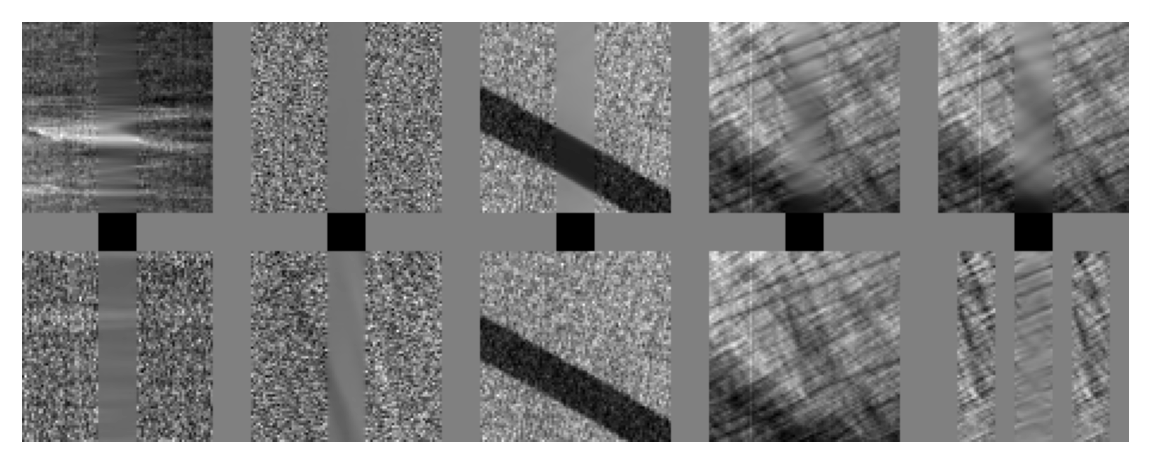

 42%|████▏     | 3571/8582 [3:33:56<4:58:25,  3.57s/it]

In [ ]:
sg.noAdv = True
sg.dataLoader = sg.createDataLoader(trainSet, num_workers=16)
sg.testLoader = sg.createDataLoader(testSet , num_workers=16)
#sg.scheduler_G = None
#sg.scheduler_D = None
#sg.normRec, sg.normMSE, sg.normL1L, _ , _ = sg.summarizeSet(sg.dataLoader)
#sg.normTestRec, sg.normTestMSE, sg.normTestL1L, _ , _ = sg.summarizeSet(sg.testLoader)
sg.normRec, sg.normMSE, sg.normL1L = 4.031e-03, 6.579e-03, 2.047e-02
sg.normTestRec, sg.normTestMSE, sg.normTestL1L = 4.868e-03, 1.382e-03, 1.369e-02
if sg.epoch == 0 :
    if sg.normRec == 1:
        sg.normRec, sg.normMSE, sg.normL1L, _ , _ = sg.summarizeSet(sg.dataLoader)
        sg.normTestRec, sg.normTestMSE, sg.normTestL1L, _ , _ = sg.summarizeSet(sg.testLoader)
    #sg.minGdLoss = sg.normTestRec
    #with torch.no_grad(): sg.generator.amplitude[()] = -math.log(1+2/sg.normMSE)

#torch.autograd.set_detect_anomaly(True)



#
#def my_afterEachEpoch(epoch) :
#    if sg.minGEpoch < 600 :
#        return
#    if not sg.dataLoader is None :
#        del sg.dataLoader
#        sg.freeGPUmem()
#    if sg.TCfg.batchSize < 131072 :
#    sg.TCfg.batchSize += round( 0.01 * sg.TCfg.batchSize )
#    sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=24)
#    print("Batch size: ",sg.TCfg.batchSize)
#sg.afterEachEpoch = my_afterEachEpoch

def my_beforeReport() :
    lastLR = sg.scheduler_D.get_last_lr()[0]
    print(f"LR : {lastLR} {lastLR/initialLR:.3f}")
    if lastLR  <  0.033 * initialLR :
        return
    if sg.scheduler_G is not None :
        sg.scheduler_G.step()
    if sg.scheduler_D is not None :
        sg.scheduler_D.step()
    return
sg.beforeReport = my_beforeReport

sg.noAdv = True

try :
    sg.train(savedCheckPoint)
except :
    del sg.dataLoader
    del sg.testLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise



## <font style="color:lightblue">Post</font>

In [ ]:
print (sg.generator.amplitude.item(), 2 * torch.sigmoid(sg.generator.amplitude).item() )
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()